<a href="https://colab.research.google.com/github/Ranga-Kulathunga/EN-4353-Radar-and-Navigation/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EN 4353 - Radar and Navigation - Assignment 01

### Index: 170318X
### Name: I.G.R.M. Kulathunga

Link to Colab Notebook: https://colab.research.google.com/drive/1ytevuzkEPORkGvIRInmwZ-cuexLCypoV?usp=sharing

# Initialization

## Import Libraries and Load the Data Files

In [203]:
# import libraries
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2 as cv
import random

plt.style.use('default')

# load .csv files
path_1 = 'https://raw.githubusercontent.com/Ranga-Kulathunga/EN-4353-Radar-and-Navigation/main/Assignment-01/raw_data1.csv' 
df_1 = pd.read_csv(path_1, sep=';', header=None, squeeze=True)

path_2 = 'https://raw.githubusercontent.com/Ranga-Kulathunga/EN-4353-Radar-and-Navigation/main/Assignment-01/raw_data2.csv' 
df_2 = pd.read_csv(path_2, sep=';', header=None, squeeze=True)

path_3 = 'https://raw.githubusercontent.com/Ranga-Kulathunga/EN-4353-Radar-and-Navigation/main/Assignment-01/raw_data3.csv'
df_3 = pd.read_csv(path_3, sep=';', header=None, squeeze=True)

# choose one data frame to analyse
"""
  raw_data1.csv --> df_1
  raw_data2.csv --> df_2
  raw_data3.csv --> df_3
"""
raw_data = df_1.to_numpy()

## Define Parameters

* Number of samples in raw_data file:
>$n = 18000$

* Initial sampling frequency:
>$F_{s\_init} = 1080\;kHz$

* Pulse Repetition Frequency (PRF): 
>$f_r = 1800\;Hz$

* Number of range slots:  
>$N = 30$ 

* Noise thresholding parameters:

    >$\sigma_n = 1$

    >$k = 1.3$    

* Speed of light: 
>$C=3\times10^{8}\;m\;s^{-1}$

* Horizontal beam width:
>$\theta_H = 2^\circ$

* Speed of rotation of the radar: 
>$\omega = 12\;rpm$

* Initial azimuth angle:
>$\theta_0 = 0^\circ$ 



In [204]:
# initialize parameters
n = len(raw_data) # number of samples in raw_data file
F_s_init = 1080*1000 # initial sampling frequency in Hz
f_r = 1800 # pulse repitition frequency in Hz
N = 30 # number of bins

sigma_n = 1
k = 1.3

C = 3e8 # speed of light in m/s
theta_H = 2 # horizontal beam width in degrees
omega = 12 # speed of rotation of the radar in rpm
theta_0 = 0 # initial azimuth angle in degrees


#Analog to Digital Conversion



##Down-sampling

* Required sampling frequency:
>$F_s = Nf_r = 30\cdot1800 = 54\;kHz$

* Sampling time:
>$T_s = \frac{1}{F_s} = 18.52\;\mu s$

* Total time taken by data frame:
>$T_{tot} = \frac{n}{F_{s\_init}} = \frac{18000}{1080000} = \frac{1}{60}\;s$

* Rovolved angle during $T_{tot}$:
>$\theta_{tot} = \frac{\omega \cdot T_{tot} \cdot 360^{\circ}}{60} = \frac{12 \cdot \frac{1}{60} \cdot 360^{\circ}}{60} = 1.2^{\circ}$

* Number of echoes per $\theta_H$:
>$n_{\theta_H} = \frac{\theta_H \cdot f_r}{6 \cdot \omega} = \frac{2 \cdot 1800}{6 \cdot 12} = 50$

* Number of echoes per $1.2^\circ$:
>$n_{1.2^\circ} = \frac{n_{\theta_H} \cdot 1.2^{\circ}}{\theta_H} = \frac{50 \cdot 1.2^{\circ}}{2} =  30$

* Dimensions of data matrix:
>$(n_{1.2^\circ}\times N)= 30\times30$

* Downsampling factor:
>$M = \frac{F_{s\_init}}{F_s} = \frac{1080}{54} = 20$

* Number of sampled data:
>$n_{sampled} = \frac{n}{M} = \frac{18000}{20} = 900$

Therefore, the raw data stream with 18000 samples is converted into $n_{sampled}\times M = 900\times20$ matrix and where $0^{th}$ column contains required samples with $54\;kHz$ and it again reshape into $30 \times 30$ matrix (sampled raw data matrix) which is the initial stage of the data matrix.

In [205]:
# downsampling the raw data
F_s = N*f_r # sampling frequency
M = F_s_init / F_s # downsampling factor
n_sampled = int(n/M) # number of sampled data

raw_matrix = raw_data.reshape(n_sampled, int(M)) # reshape raw data into 900x20 matrix

T_tot = n/F_s_init # total time taken by the raw data frame
theta_tot = omega*n*6/F_s_init # revoled angle during T_tot time period

n_echo_theta_H = (theta_H*f_r)/(6*omega) # number of echoes per theta_h
n_echo_theta_tot = int((n_echo_theta_H * theta_tot)/theta_H) # number of echoes per theta_tot

sampled_matrix = raw_matrix[:, 0].reshape(n_echo_theta_tot, N) # reshape 0th column of initial matrix into 30x30 data matrix

##Visualization of Sampled Raw Data Matrix

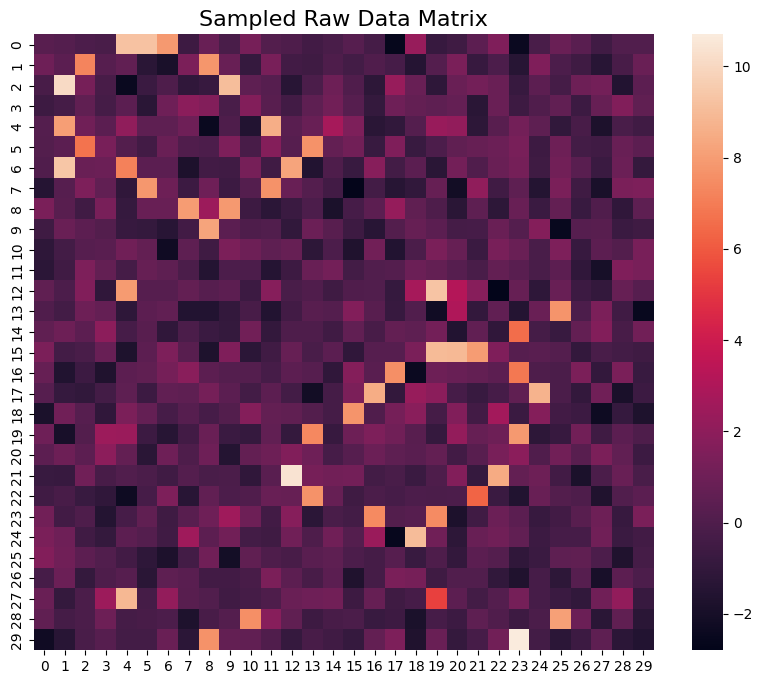

In [206]:
f, ax = plt.subplots(figsize=(10,8))
plt.title("Sampled Raw Data Matrix",fontsize = 16)
ax = sns.heatmap(sampled_matrix, square=False, annot=False, cbar=True)

#CFAR Thresholding

##Noise Averaging

Noise threshold value for each sample can be calculated as follows;
>$V_{TH}=(V_n)_{avg}+V_x$

>$V_{TH}=(V_n)_{avg}+k\cdot \sigma_n$

As Constant False Alarm Rate (CFAR) thresholding is used, threshold voltage $V_{TH}$ is dynamically changing to keep False Alarm Probability $P_{fa}$ constant by changing average noise $(V_n)_{avg}$ dynamically and remaining $V_x$ fixed. 

$(V_n)_{avg}$ should be calculated for each sample in sampled data set (at $54\;kHz$) to perform threshold detection.

For the noise averaging algorithm, a window size of 21 on the original samples (at $1080\;kHz$) and a guard band of 4 are used to determine $(V_n)_{avg}$ for a particular range slot. Therefore, $(V_n)_{avg}\:$ for $k^{th}$ sample can be obtained as;

>$(V_n)_{avg} = \frac{\sum_{i=k-5}^{k-10} (past\;video) + \sum_{i=k+5}^{k+10} (future\;video)}{12}$

As the figure shown below, number of samples in past video is 6, future video is 6 and guard band size is 4 samples per one side.

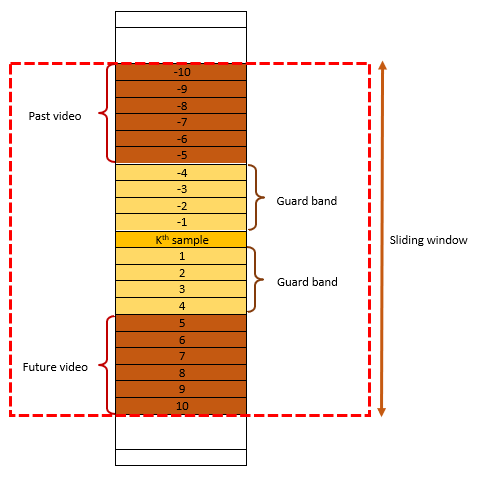

**Note:** Past video data for $0^{th} sample\:$ is not available so only the future video data is considered in this assignment.

After calculating $(V_n)_{avg}$, $V_{TH}$ is found easily if $k$ and $\sigma_n$ are known. Values of $k$ and $\sigma_n$ considered for this assignment are initialized in Initialization section above.

Noise average is considered as a $30 \times 30$ matrix for the simplicity of the calculations.

In [207]:
# define parameters
w = 21 # window size
g = 4 # size of guard band
m = int((w-1)/2)

# function to calculate threshold for each sample and output as a vector
def threshold_calculator(samples_set, m, g, k, sigma_n):

  # size of sample set
  l = len(samples_set)
  c = len(samples_set[0])

  # define future video for each sample
  future_video = samples_set[:, g+1:m+1]

  # define past video for each sample. 
  # duplicates the future video of 0 th sample to the past video
  temp = samples_set[:l-1, c-m:c-g]
  past_video = np.vstack([future_video[0], temp])

  # noise average as a vector
  v_n_avg = np.mean(np.concatenate((future_video, past_video),axis=1),axis=1)

  # threshold vector
  V_TH_vec = v_n_avg + k*sigma_n

  return V_TH_vec

V_TH = threshold_calculator(raw_matrix, m, g, k, sigma_n).reshape(n_echo_theta_tot,N)

##Visualization of Thresholding

Sample amplitudes and threshold values for each sample in a random pulse is considered here.

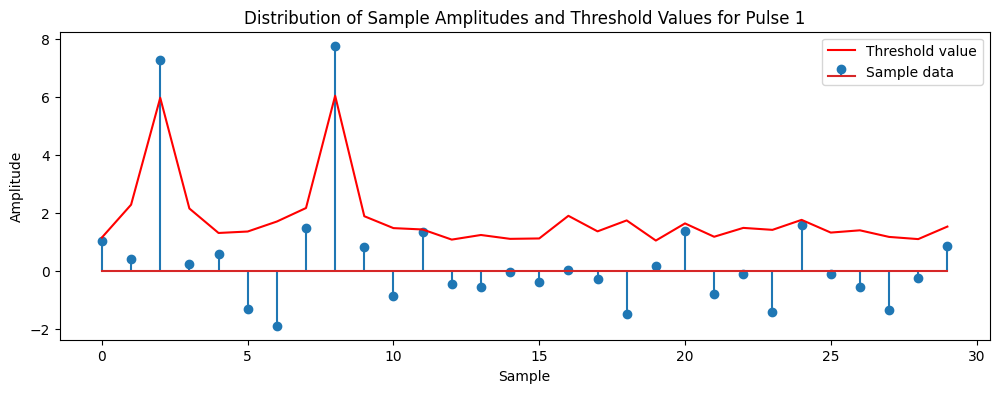

In [208]:
# randomly choose a pulse to plot
pulse = random.randint(0, 29)

# plot the sample amplitudes with thresholding values
plt.figure(figsize=(12, 4))
ax = plt.stem(sampled_matrix[pulse, 0:30], use_line_collection=True, label='Sample data')
ax = plt.plot(V_TH[pulse, 0:30], color='r', label='Threshold value')
ax = plt.ylabel('Amplitude')
ax = plt.xlabel('Sample')
ax = plt.title('Distribution of Sample Amplitudes and Threshold Values for Pulse %d' % pulse)
ax = plt.legend()
plt.show()

##Threshold Detection

Sample amplitude are compared with the threshold value and are mapped into binary output as follows;

>$If\;\;V_{K}>V_{TH} \\\;\;Then \;\;\textbf{output} = 1 \\ \;\;Otherwise\;\;\textbf{output} = 0$

Threshold detector binary output can be arranged as another type of memory called data matrix.

In [209]:
# binary mapping function
def threshold_detector(data, ref):
  return (data > ref)*1

# create data matrix
data_matrix = threshold_detector(sampled_matrix, V_TH)

##Visualization of Data Matrix

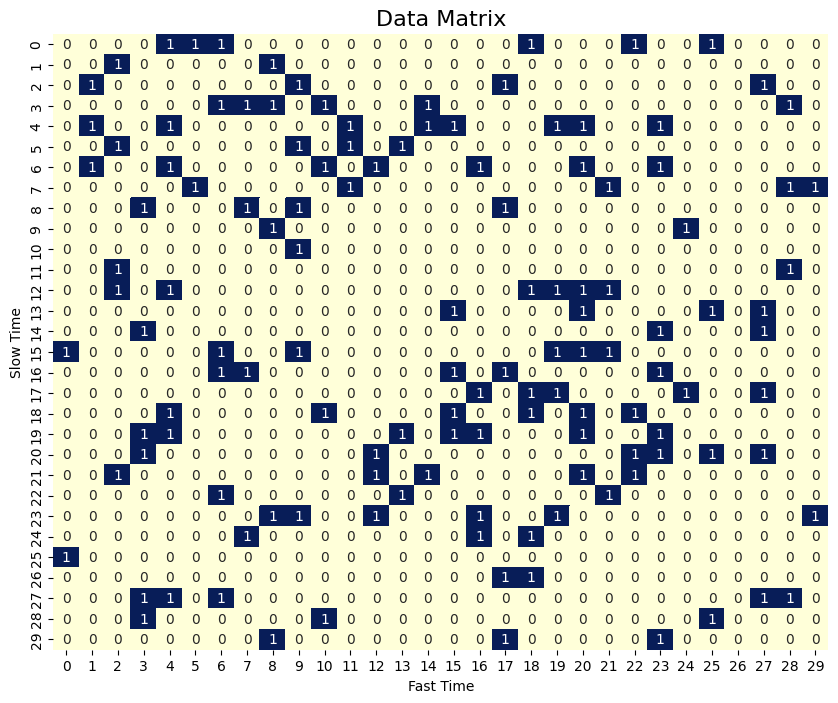

In [210]:
f, ax = plt.subplots(figsize=(10, 8))
plt.title("Data Matrix", fontsize = 16)
ax = sns.heatmap(data_matrix, square=False, annot=True, cbar=False, cmap="YlGnBu")
ax = ax.set(xlabel="Fast Time", ylabel="Slow Time")

#Post Detection Integration

##Non-coherent Binary Integration

Non-coherent binary integration is used to perform post detection integration. Binary integration is a very simple and low cost integration method that can be controlled easily using DSP. Number of non-zero cells along each column of data matrix is taken as count for the corresponding range slot.

>$If\;\;\textbf{count} > 0.5\times[\textbf{Expected echoes per target per scan}] \\
\;\;Then\;\;\textbf{there is a target in that range slot}$

Related parameters are defined as follows,
* Expected echoes per target per scan:
>$n_{1.2^\circ} =  30$

* Threshold value for count:
>$count_{TH} = 0.5\times n_{1.2^\circ} = 0.5\times 30 = 15$

All cells along a column of the data matrix is replaced by 0.5 if a target is present in corresponding range slot. 

In [211]:
# Threshold value for count
count_TH = 0.5*n_echo_theta_tot

# fuction to detect the targets/objects
def object_detector(matrix, count_TH):

  matrix = matrix.astype(np.float64)
  range_sum = np.sum(matrix, axis=0)
  object_bins = []
  for i,(entry) in enumerate(range_sum):
    if entry >= count_TH:
      object_bins.append(i)
      matrix[:, i] = 0.5 

  return matrix, object_bins

# find data matrix with detected targets and number of objects
matrix_tar_detected, objects = object_detector(data_matrix, count_TH)

##Visualization of Post Detection Integaration

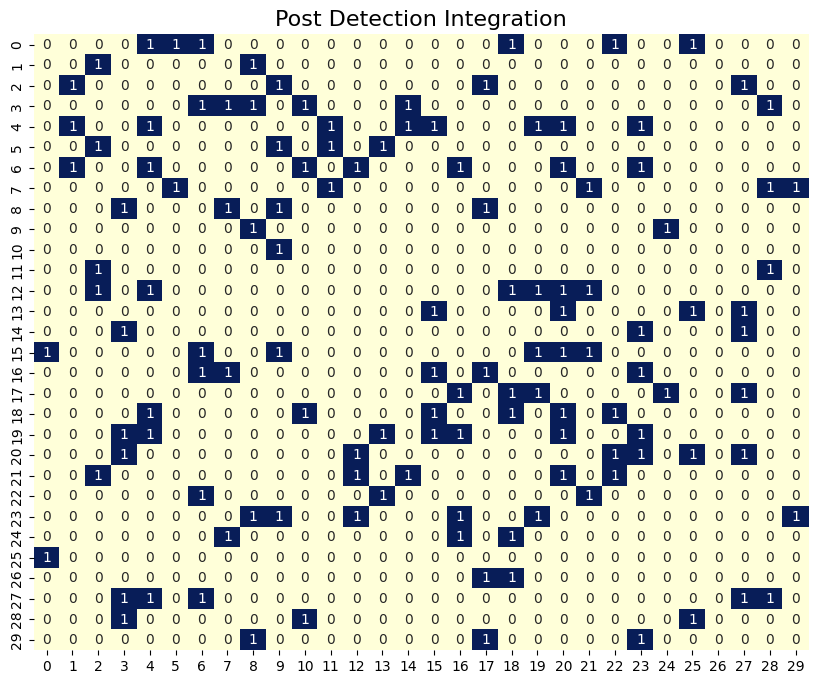

In [212]:
f, ax = plt.subplots(figsize=(10,8))
plt.title('Post Detection Integration', fontsize = 16)
ax = sns.heatmap(matrix_tar_detected, square=False, annot=True, cbar=False, cmap="YlGnBu")

#Cloud Detection

##Thresholding

CFAR thresholding does not remove all unwanted noise so further thresholding should be applied before filtering.

The noise detected by CFAR thresholding is removed from sampled data as follows,
>$If\;\;V_{K} > V_{TH} \\ \;\; Then \;\;\textbf{output} = V_K \\ \;\;Otherwise\;\;\textbf{output} = 0$

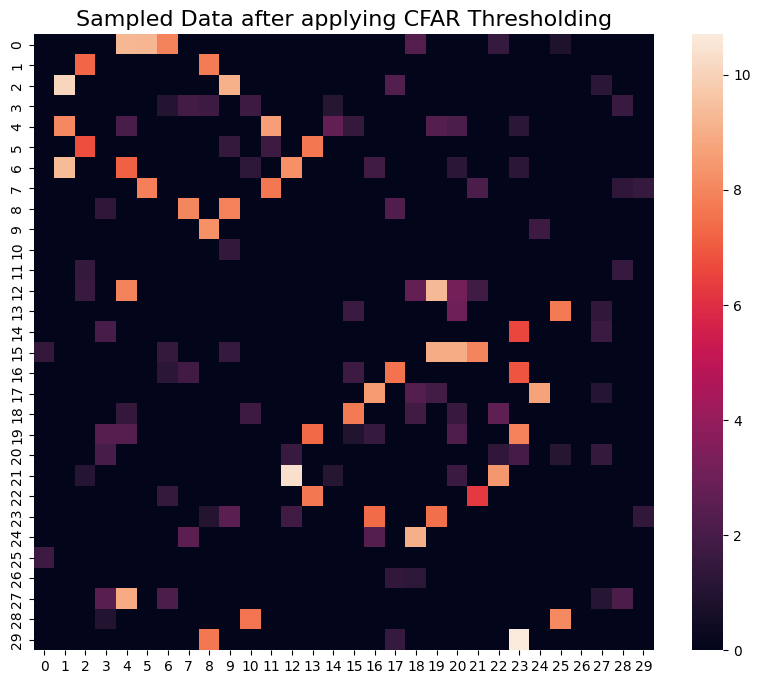

In [213]:
# remove noise detected by CFAR thresholding
matrix_TH1 = np.multiply(sampled_matrix, data_matrix)

f, ax = plt.subplots(figsize=(10, 8))
plt.title('Sampled Data after applying CFAR Thresholding', fontsize = 16)
ax = sns.heatmap(matrix_TH1, square=False, annot=False, cbar=True)

By observing the image above, new threshold value is marked as $V_{TH} = 6$ to remove unwanted noise that are not detected by CFAR thresholding.
>$If\;\;V_{K} > 6 \\ \;\; Then \;\;\textbf{output} = V_K \\ \;\;Otherwise\;\;\textbf{output} = 0$

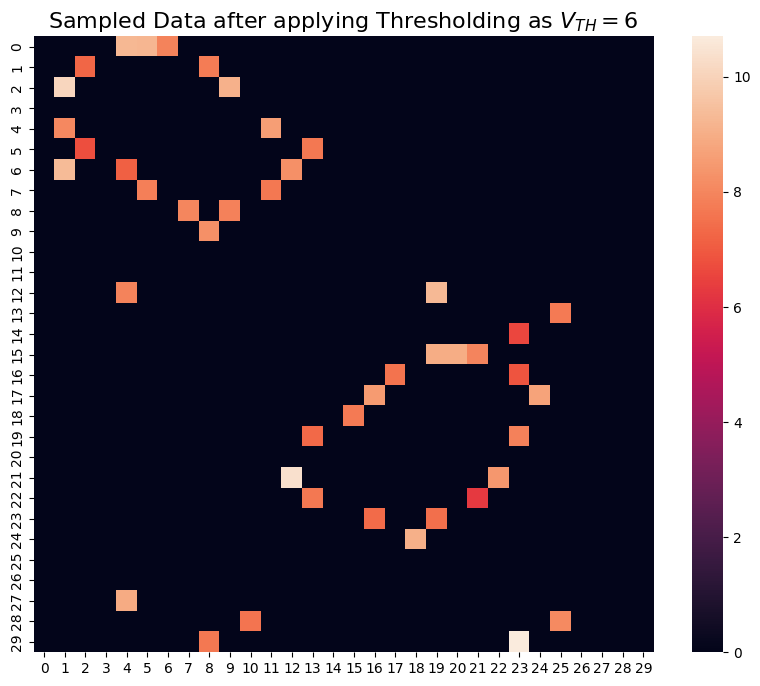

In [214]:
# define new threshold value
V_TH_new = 6

# remove noise after applying new threshold
matrix_TH2 = np.where(matrix_TH1 > V_TH_new, matrix_TH1, 0)

f, ax = plt.subplots(figsize=(10, 8))
plt.title('Sampled Data after applying Thresholding as $V_{TH} = %i$' %V_TH_new, fontsize = 16)
ax = sns.heatmap(matrix_TH2, square=False, annot=False, cbar=True)

For simplicity of cloud detection, the sampled data is converted into binary format as follows,

>$If\;\;V_{k}>0 \\ \;\; Then \;\;\textbf{output} = 1 \\ \;\;Otherwise\;\;\textbf{output} = 0$

In addition to that, the range slots with objects are removed from data matrix temporally to identify clouds clearly.

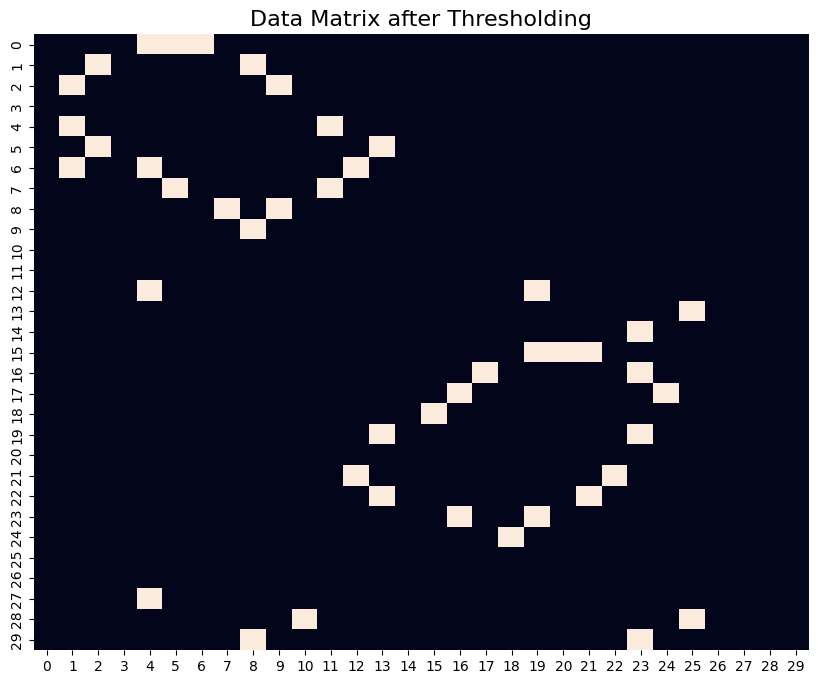

In [215]:
# convert filtered matrix into binary
matrix_binary = np.where(matrix_TH2 > 0, 1, 0)

# remove object for simplicity of detection of clouds
matrix_binary[:, objects] = 0

f, ax = plt.subplots(figsize=(10, 8))
plt.title('Data Matrix after Thresholding', fontsize = 16)
ax = sns.heatmap(matrix_binary, square=False, annot=False, cbar=False)

##Filtering

###Inner Filtering

Filtering Binary matrix after performing thresholding is filtered by selecting a kernel and moving it within matrix as follows,

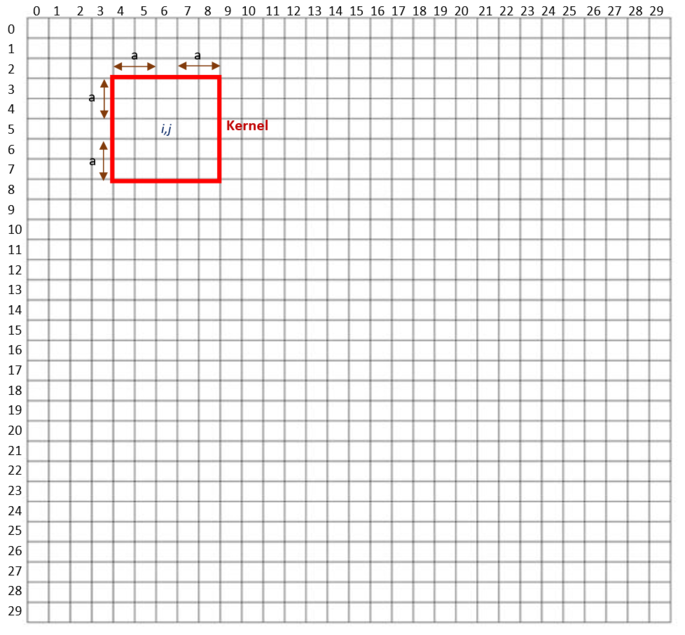

Parameters related to inner filtering are defined as follows,

* Kernel Offset:
> $a = 2$

* Size of Kernel:
> $(2\cdot a +1)\times(2\cdot a +1) = 5\times 5$

* Kernel:
>$kernel = Binary\;Matrix\;\;[i-a:i+a, j-a:j+a]$

* Summation of Kernel:
>$kernel\_sum = \sum{(kernel)}$

* Threshold:
>$TH = 2$

* Condition for filtering:
>$If\;\;kernel\_sum < TH \\ \;\; Then \;\;Binary\;Matrix\;[i-a+1:i+a-1, j-a+1:j+a-1] = 0$


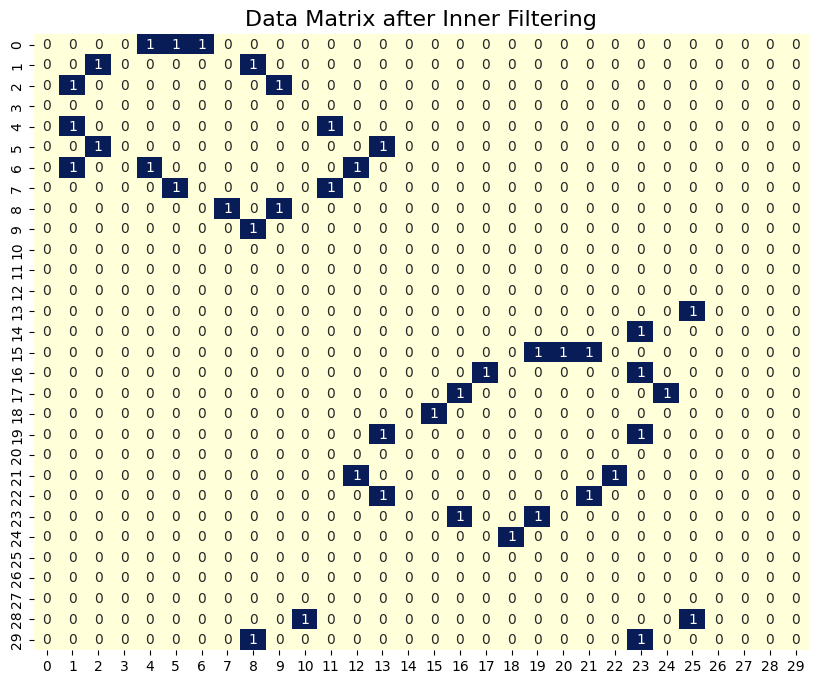

In [216]:
# define parameters
a_inner = 2 # kernel offset
TH_inner = 2 # threshold

# perform filtering to remove unwanted noise
def inner_filtering(matrix, kernel_offset_inner, threshold_inner):
  r, c = matrix.shape

  for i in range(0+kernel_offset_inner, r-kernel_offset_inner):
    for j in range(0+kernel_offset_inner, c-kernel_offset_inner):
      kernel = matrix[i-kernel_offset_inner:i+kernel_offset_inner+1, j-kernel_offset_inner:j+kernel_offset_inner+1]
      kernel_sum = np.sum(kernel)

      if matrix[i, j]:
        if kernel_sum < threshold_inner:
          matrix[i-kernel_offset_inner+1:i+kernel_offset_inner, j-kernel_offset_inner+1:j+kernel_offset_inner] = 0

  return matrix

# filtering noise from binary matrix
matrix_filtered = inner_filtering(matrix_binary, a_inner, TH_inner)

f, ax = plt.subplots(figsize=(10, 8))
plt.title('Data Matrix after Inner Filtering', fontsize = 16)
ax = sns.heatmap(matrix_filtered, square=False, annot=True, cbar=False, cmap="YlGnBu")

###Outer Filtering

Noise at boundary of the data matrix is not removed by inner filtering. Hence, another filering algorithm is needed to remove noise at data matrix boundary. There are four outer most boundary lines in a matrix as follows,
* Top most row
* Bottom most row
* Left most column
* Right most column

The total number of boundary lines are defined with respect to the kernel offset of inner filtering algorithm.

* Total Number of Boundary Lines:
>$n_{boundary\_lines} = 4 \times kernel\;offset\;of\;inner\;filtering$

A new kernel is defined for outer filtering as follows,

* Kernel Offset:
> $a = 3$

**For row boundary lines:**
* Size of Kernel:
> $(1)\times(2\cdot a +1) = 1\times 7$

* Kernel:
>$row\;kernel = Binary\;Matrix\;\;[i, j-a:j+a]$

* Summation of Kernel:
>$row\_kernel\_sum = \sum{(row\_kernel)}$

* Threshold:
>$TH = 2$

* Condition for filtering:
>$If\;\;row\_kernel\_sum < TH \\ \;\; Then \;\;Binary\;Matrix\;[i, j-a+1:j+a-1] = 0$

**For column boundary lines:**
* Size of Kernel:
> $(2\cdot a +1)\times (1) = 7\times 1$

* Kernel:
>$column\;kernel = Binary\;Matrix\;\;[i-a:i+a, j]$

* Summation of Kernel:
>$column\_kernel\_sum = \sum{(column\_kernel)}$

* Threshold:
>$TH = 2$

* Condition for filtering:
>$If\;\;column\_kernel\_sum < TH \\ \;\; Then \;\;Binary\;Matrix\;[i-a+1:i+a-1, j] = 0$

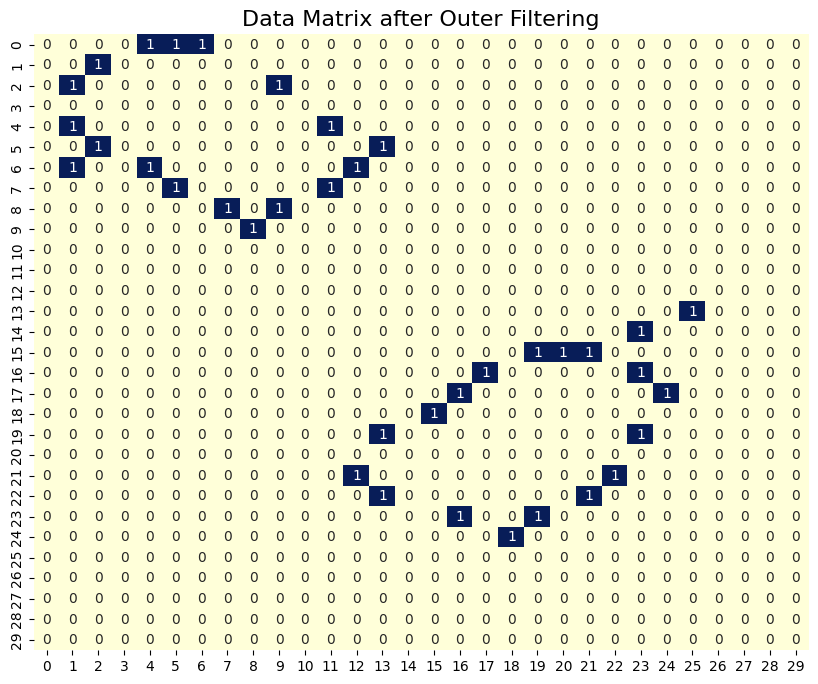

In [217]:
# define parameters
a_outer = 3 # kernel offset
TH_outer = 2 # threshold

# function to remove noise at matrix boundary
def outer_filtering(matrix, kernel_offset_outer, threshold_outer, kernel_offset_inner):
  r, c = matrix.shape

  row_bound_l = np.array(range(0, kernel_offset_inner))
  row_bound_u = np.array(range(r-kernel_offset_inner, r))
  row_bound = np.concatenate((row_bound_l, row_bound_u))
  for i in row_bound:
    for j in range(0+kernel_offset_outer, c-kernel_offset_outer):
      row_kernel = matrix[i, j-kernel_offset_outer:j+kernel_offset_outer+1]
      row_kernel_sum = np.sum(row_kernel)

      if matrix[i, j]:
        if row_kernel_sum < threshold_outer:
          matrix[i, j-kernel_offset_outer+1:j+kernel_offset_outer] = 0

  col_bound_l = np.array(range(0, kernel_offset_inner))
  col_bound_u = np.array(range(c-kernel_offset_inner, c))
  col_bound = np.concatenate((col_bound_l, col_bound_u))
  for j in col_bound:
    for i in range(0+kernel_offset_outer, c-kernel_offset_outer):
      col_kernel = matrix[i-kernel_offset_outer:i+kernel_offset_outer+1, j]
      col_kernel_sum = np.sum(col_kernel)

      if matrix[i, j]:
        if col_kernel_sum < threshold_outer:
          matrix[i-kernel_offset_outer+1:i+kernel_offset_outer, j] = 0
  return matrix

# filter noise at boundary of data matrix
matrix_filtered = outer_filtering(matrix_filtered, a_outer, TH_outer, a_inner)

f, ax = plt.subplots(figsize=(10,8))
plt.title('Data Matrix after Outer Filtering', fontsize = 16)
ax = sns.heatmap(matrix_filtered, square=False, annot=True, cbar=False, cmap="YlGnBu")

###Corner Filtering

As the boundary, four corner edges of data matrix are not filtered by inner or outer filtering. Corner filtering is introduced to overcome this issue. A new kernel can be selected and moved within four edges. At each corner, sum of the kernel is taken and compared with a particular threshold value. This is also same as inner/outer filtering and can be done easily.

**Note:** Corner filtering is not performed in this assignment. But it can be applied easily if we want.

##Edge Filling

Filtered matrix is used to fill the cloud edges by selecting a kernel and moving it within matrix.

Related parameters are defined as follows,

* Kernel Offset:
> $a = 3$

* Size of Kernel:
> $(a +1)\times(a +1) = 4\times 4$

* Kernel:
>$kernel = Filtered\;Matrix\;\;[i:i+a, j:j+a]$

Selected kernel is shown below,

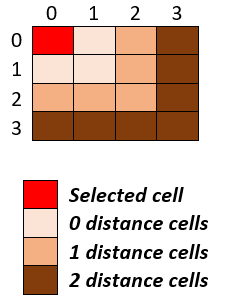

Edge filling is performed by analysing the kernel with respect to the selected cell ($(0, 0)$ cell in the kernel/ $(i, j)$ cell in Filtered Matrix).

If the selected cell is non-empty, then find the nearest non-empty cells and perform edge filling according to the distance from selected cell to nearest cell as follows,

* If the nearest cell be in 0 distance region, then the filtered matrix is not changed.

* If the nearest cell be in 1-distance region, then the filling between two non-empty cells is done as follows,

>>$If\;\;kernel\;[0,2] == 1\\ 
  \;\;Then\;\;Filtered\;Matrix\;[i,j+1] = 1$

>>$If\;\;kernel\;[2,0] == 1\\ 
  \;\;Then\;\;Filtered\;Matrix\;[i+1,j] = 1$

>>$If\;\;kernel\;[1,2] == 1\;\;kernel\;[2,2] == 1\;\;kernel\;[2,1] == 1\\ 
  \;\;Then\;\;Filtered\;Matrix\;[i,j+1] = 1$

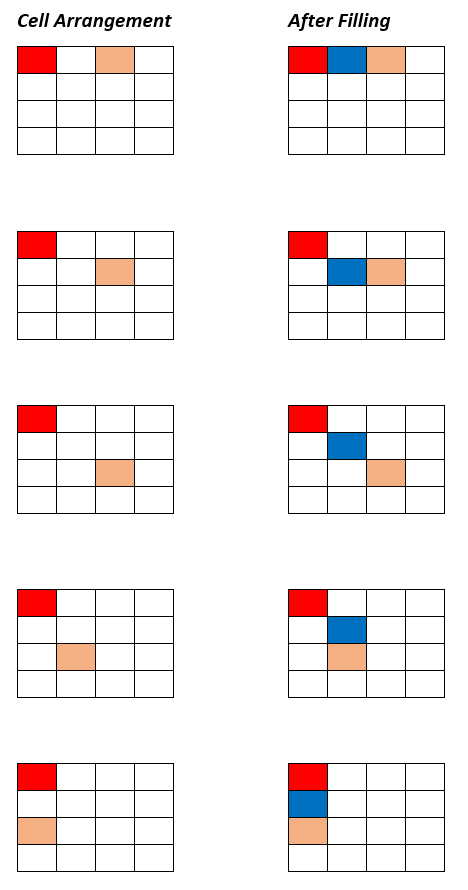

* If the nearest cell be in 2-distance region, then the filling between two non-empty cells is done as follows,

>>$If\;\;kernel\;[0,3] == 1\\ 
  \;\;Then\;\;Filtered\;Matrix\;[i,j+1:j+2] = 1$

>>$If\;\;kernel\;[3,0] == 1\\ 
  \;\;Then\;\;Filtered\;Matrix\;[i+1:i+2, j] = 1$
  
>>$If\;\;kernel\;[1,3] == 1\\ 
  \;\;Then\;\;Filtered\;Matrix\;[i,j+1] = 1\;\;and\;\;Filtered\;Matrix\;[i+1, j+2] = 1$

>>$If\;\;kernel\;[3,1] == 1\\ 
  \;\;Then\;\;Filtered\;Matrix\;[i+1, j] = 1\;\;and\;\;Filtered\;Matrix\;[i+2, j+1] = 1$

>> $If\;\;kernel\;[2,3] == 1\\ 
  \;\;Then\;\;Filtered\;Matrix\;[i+1,j+1:j+2] = 1$

>> $If\;\;kernel\;[3,2] == 1\\ 
  \;\;Then\;\;Filtered\;Matrix\;[i+1,j+1:j+2] = 1$

>>$If\;\;kernel\;[3,3] == 1\\ 
  \;\;Then\;\;Filtered\;Matrix\;[i+1, j+1] = 1\;\;and\;\;Filtered\;Matrix\;[i+2, j+2] = 1$

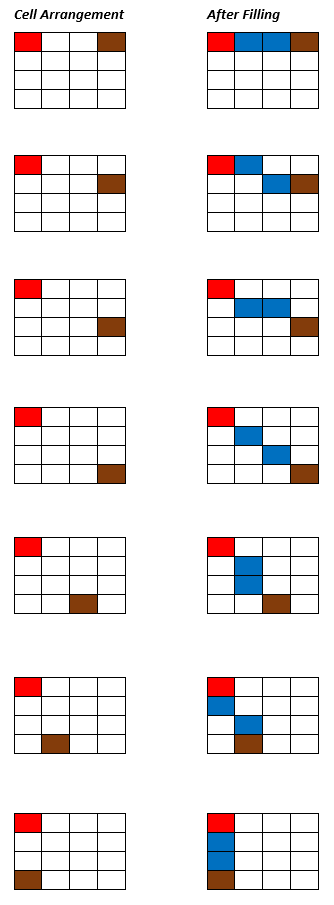

The filling using the above kernel does not fill edges completely because it fills only the gaps that are from left to right direction. However, there are gaps from right to left direction that are not filled by the above filling. To overcome this issue and to complete the edge filling, the filling is performed for two different kernels as shown below,

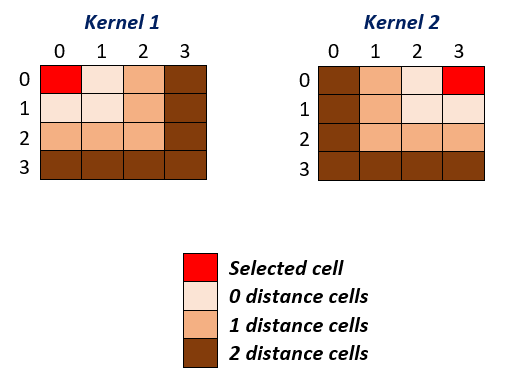

Instead of selecting two different kernels, there is an alternative method to fill all the gaps using only one kernel (*kernel 1*) as follows,

* Perform the filling algorithm for the filtered matrix by selecting *kernel 1*. This is called first cloud edge filling.
* Flip the resultant matrix.
* Perform the filling algorithm for the flipped matrix by selecting *kernel 1*. This is called second cloud edge filling.
* Flip the resultant matrix.

After performing the above steps, a data matrix have been created with edge-filled clouds.


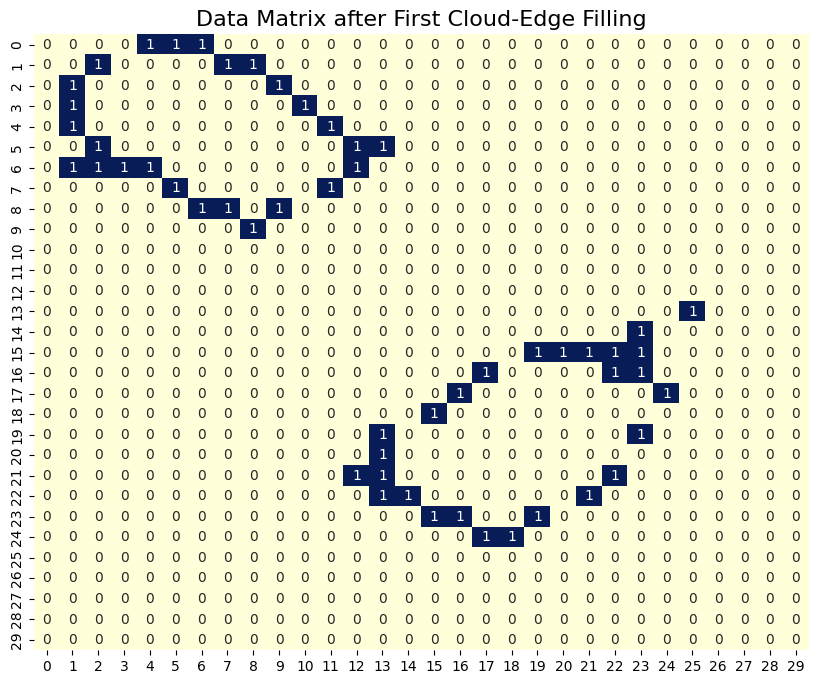

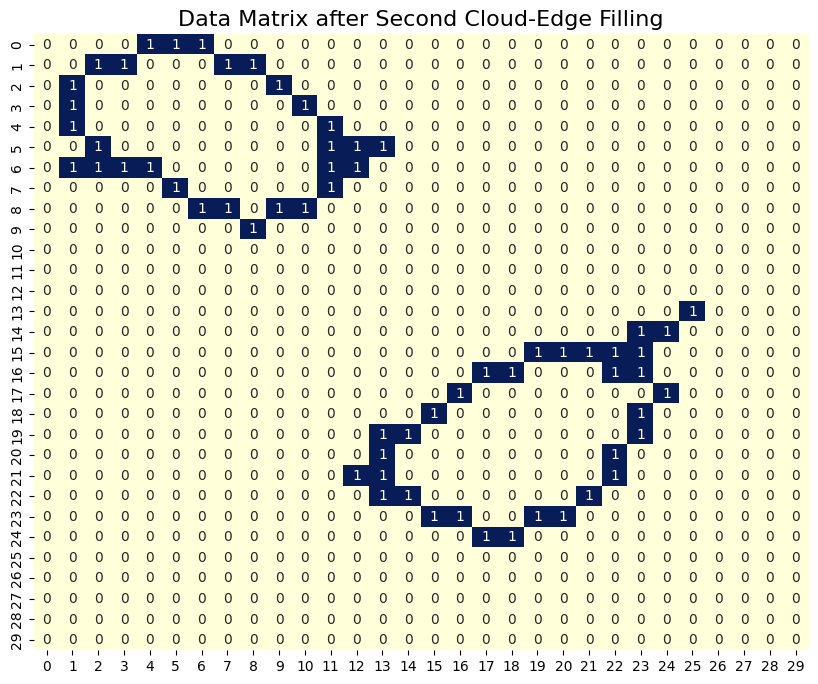

In [218]:
# fill 1-distance cell gaps
def fill_1(matrix, kernel, i, j):

  if kernel[0, 2]:
    matrix[i, j+1] = 1
  if kernel[2, 0]:
    matrix[i+1, j] = 1
  if (kernel[1, 2] or kernel[2, 2] or kernel[2, 1]):
    matrix[i+1, j+1] = 1

  return matrix

# fill 2-distance cell gaps
def fill_2(matrix, kernel, i, j):

  if kernel[0, 3]: 
    matrix[i, j+1:j+3] = 1
  if kernel[3, 0]:
    matrix[i+1:i+3, j] = 1

  if kernel[1, 3]:
    matrix[i, j+1] = 1
    matrix[i+1, j+2] = 1
  if kernel[3, 1]:
    matrix[i+1, j] = 1
    matrix[i+2, j+1] = 1

  if kernel[2, 3]:
    matrix[i+1, j+1:j+3] = 1
  if kernel[3, 2]:
    matrix[i+1:i+3, j+1] = 1

  if kernel[3, 3]:
    matrix[i+1, j+1] = 1
    matrix[i+2, j+2] = 1

  return matrix

# function for the edge filling
def filling_edg(matrix, kernel_offset):
  r, c = matrix.shape

  for i in range(0, r-kernel_offset):
    for j in range(0, c-kernel_offset):

      kernel = matrix[i:i+kernel_offset+1, j:j+kernel_offset+1]

      if matrix[i, j]:

        # check for 0-distance cell gaps
        if (kernel[0, 1] or kernel[1, 1] or kernel[1, 0]): 
          continue

        # filling when 3x3 kernel is selected
        elif kernel_offset == 2:

          # check for 1-distance cell gaps
          matrix = fill_1(matrix, kernel, i, j)

        # filling when 4x4 kernel is selected
        else:

          # check for 1-distance cell gaps 
          if (np.any(matrix[i:i+3, j+2]) or np.any(matrix[i+2, j:j+3].any())):
            matrix = fill_1(matrix, kernel, i, j)

          # check for 2-distance cell gaps
          else:
            matrix = fill_2(matrix, kernel, i, j)

  return matrix

# perform filling for filtered matrix
matrix_edg_filled_1 = filling_edg(matrix_filtered, 3)

f, ax = plt.subplots(figsize=(10,8))
plt.title('Data Matrix after First Cloud-Edge Filling', fontsize = 16)
ax = sns.heatmap(matrix_edg_filled_1, square=False, annot=True, cbar=False, cmap="YlGnBu")

# flip the first filled matrix
matrix_flipped_1 = np.flip(matrix_edg_filled_1, axis=1)

# perform filling for the flipped matrix
matrix_edg_filled_2 = filling_edg(matrix_flipped_1, 3)

# flip the second filled matrix
matrix_flipped_2 = np.flip(matrix_edg_filled_2,axis=1)

matrix_edg_filled = matrix_flipped_2

f, ax = plt.subplots(figsize=(10,8))
plt.title('Data Matrix after Second Cloud-Edge Filling', fontsize = 16)
ax = sns.heatmap(matrix_edg_filled, square=False, annot=True, cbar=False, cmap="YlGnBu")

##Contour Filling

Floodfill algorithm is used to fill the contour within the boundary of the clouds as follows,

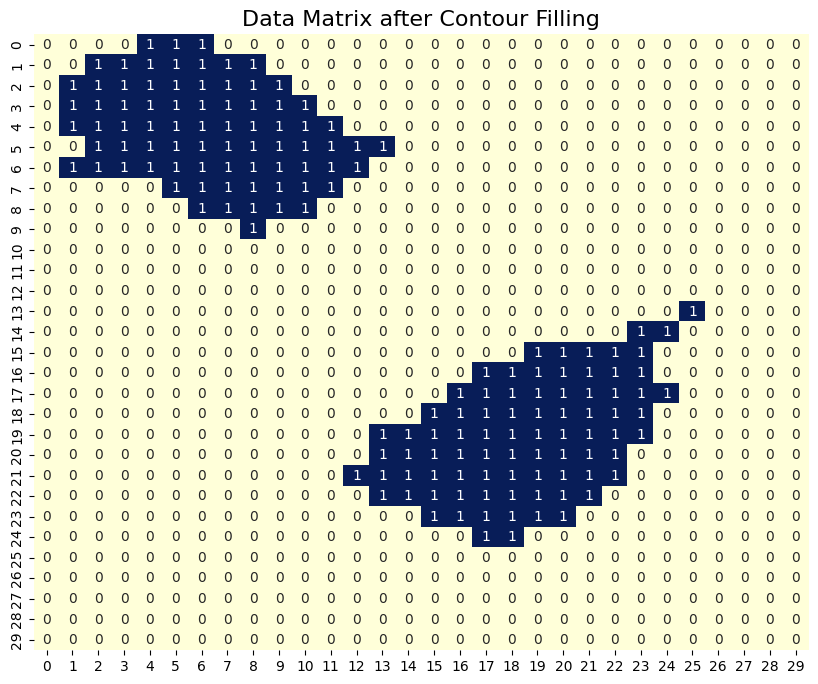

In [219]:
matrix_uint = matrix_edg_filled.astype(np.uint8)
floodFill = cv.floodFill(matrix_uint, None, seedPoint=(0, 0), newVal=10)

matrix_con_filled = floodFill[1].reshape(n_echo_theta_tot, N)
matrix_con_filled = np.where(matrix_con_filled == 10, 0, 1)

f, ax = plt.subplots(figsize=(10,8))
plt.title('Data Matrix after Contour Filling', fontsize = 16)
ax = sns.heatmap(matrix_con_filled, square=False, annot=True, cbar=False, cmap="YlGnBu")

After completing all the steps in cloud detection, filtering is performed again in order to removing noise that is not removed by the first filtering stage.

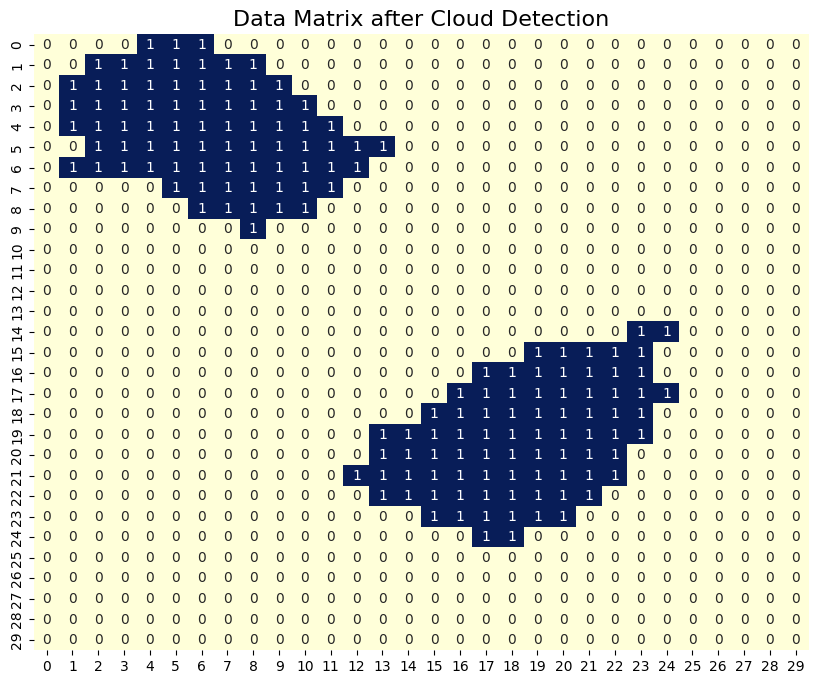

In [220]:
# filter the resultant matrix and get final matrix
matrix_final = inner_filtering(matrix_con_filled, 1, 3) # kernel offset = 1 and threshold = 3
matrix_final = outer_filtering(matrix_final, 3, 3, 1) # kernel_offset = 3 and threshold = 3

f, ax = plt.subplots(figsize=(10,8))
plt.title('Data Matrix after Cloud Detection', fontsize = 16)
ax = sns.heatmap(matrix_final, square=False, annot=True, cbar=False, cmap="YlGnBu")

#Final Results

##Final Data Matrix

After completing all the steps in cloud detection algorithm, all the detected objects are added again into the data matrix.

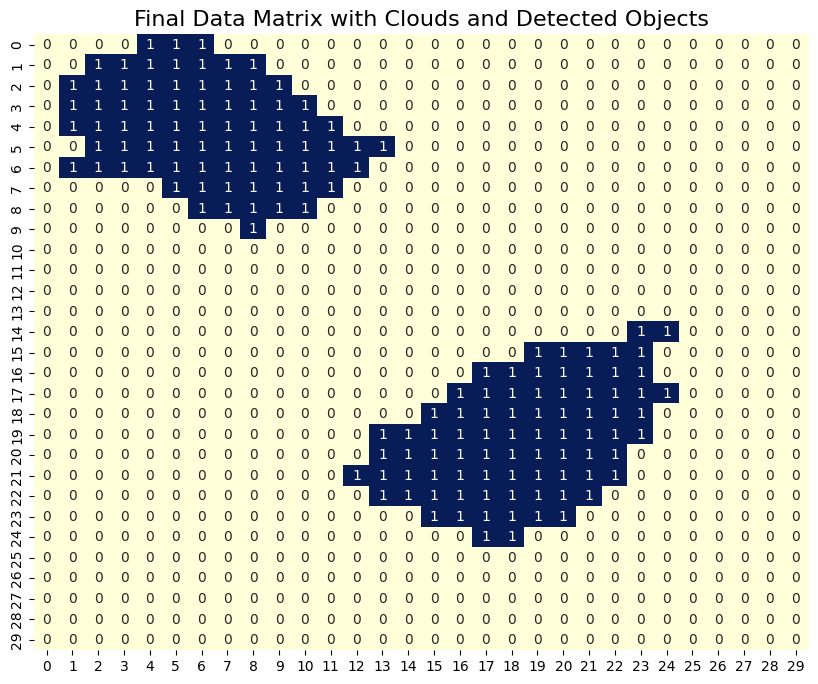

In [221]:
# add object into the matrix after cloud detection
data_matrix_final = matrix_final.astype(np.float64)
data_matrix_final[:,objects] = 0.5

f, ax = plt.subplots(figsize=(10, 8))
plt.title('Final Data Matrix with Clouds and Detected Objects', fontsize = 16)
ax = sns.heatmap(data_matrix_final, square=False, annot=True, cbar=False, cmap="YlGnBu")

##Radar Display

All the detected targets can be plotted in radar display if the range and azimuth angle of targets are known.

**Range Calculations:**

* Range Slot Size:
>$\Delta R = \frac{C}{2 F_s} = \frac{3\times 10^8}{2\cdot 54\times 10^3} = 2777.778\;m$

* Range:
>$r_k = range \;slot\;number\;of\;object \times \Delta R$

**Azimuth Angle Calculations:**

* Since $n_{\theta_H} = 50$ and $n_{1.2^\circ} = 30$, $n_{\theta_H} > n_{1.2^\circ}$

* Azimuth Angle:
>$\theta_k = [n_{1.2^\circ} + \frac{n_{\theta_H} - n_{1.2^\circ}}{2}] \frac{ω}{f_r} = [30 + \frac{50-30}{2}]\times \frac{\frac{12\times360}{60}}{1800} = 1.6\;deg/sec$

In [222]:
n_objects = len(objects) # number of objects

# check for the objects
if n_objects:
  delta_R = C/(2*F_s) # length of delta R bin
  r_k = np.dot(delta_R, np.add(objects, 1)) # range for all objects
  theta_k = np.dot(np.ones(n_objects), ((n_echo_theta_tot + n_echo_theta_H)/2)*(omega*6/f_r))  # azymath for all objects

  # print azymath and range of all targets
  for i,(r, theta) in enumerate(zip(r_k, theta_k)):
    print(f'Target {i+1} is at ({r*1e-3:.3f} km, {theta:.3f} deg)')

else:
  print('No target detected')
  theta_k = []
  r_k = []

No target detected


After finding range and azimuth for all targets, they are plotted in radar display as follows.

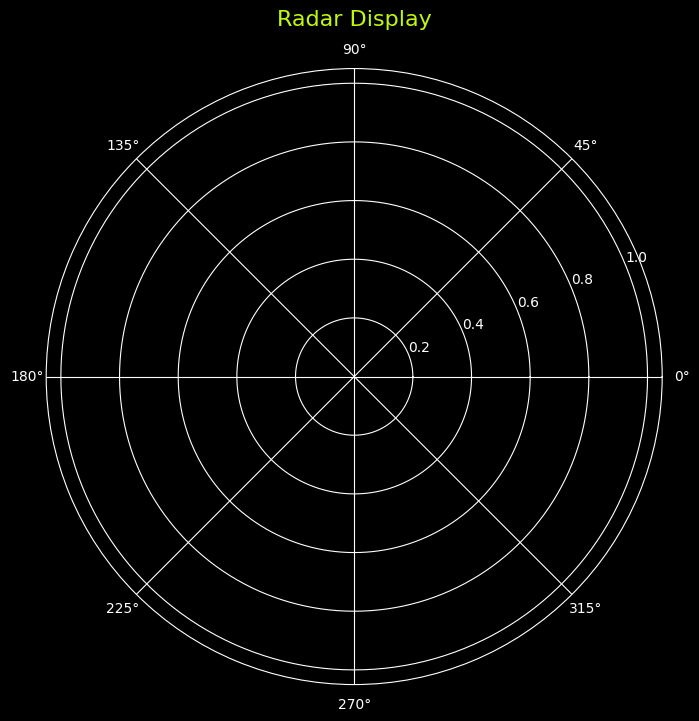

In [223]:
# plot the radar display
def radar_display(azimuth, range):
  
  # convert the range into km and azimuth into radian
  if len(range) !=0:
    range = range/1000
    azimuth = azimuth*np.pi/180

  fig = plt.figure(figsize=(8,8))
  plt.style.use('dark_background')
  x, y = (0,0)                                                                    
  font_dict = {'size':'12', 'color':'xkcd:chartreuse'}
  plt.polar()   
  fig.set_facecolor('xkcd:black')

  # plot all targets in radar display
  for i, (r, theta) in enumerate(zip(range, azimuth)):
    plt.polar(theta, r, 'ro', markersize=10)                           
    str_ = f'T:0{i+1}\n({r:.2f} km, {theta*180/np.pi:.2f} deg)'
    plt.text(theta-0.05, r+0.1, str_, font_dict)                    

  plt.title('Radar Display', {'size':'16', 'color':'xkcd:chartreuse', 'weight':'normal',
          'verticalalignment':'bottom'})
  fig.show()

# Plot targets in radar display for the given data set 
ax = radar_display(theta_k, r_k)